
# Image Classification Tutorial with the MedNIST Dataset

Introduction
In this tutorial, we introduce an end-to-end training and evaluation example based on the MedNIST dataset.
We'll go through the following steps:

- Create a MONAI Dataset for training and testing
- Use MONAI transforms to pre-process data
- Use the DenseNet from MONAI for the classification task
- Train the model with a PyTorch program
- Evaluate on test dataset

### Get the dataset
The MedNIST dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions), [the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4), and [the NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

The dataset is kindly made available by [Dr. Bradley J. Erickson M.D., Ph.D.](https://www.mayo.edu/research/labs/radiology-informatics/overview) (Department of Radiology, Mayo Clinic) under the Creative Commons [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/). If you use the MedNIST dataset, please acknowledge the source, e.g.

https://github.com/Project-MONAI/MONAI/blob/master/examples/notebooks/mednist_tutorial.ipynb.

The following commands download and unzip the dataset (~60MB).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install MONAI

In [ ]:
!pip install -q "monai-weekly[gdown, nibabel, tqdm, itk]"

     |████████████████████████████████| 501kB 20.9MB/s 
     |████████████████████████████████| 81kB 12.6MB/s 
     |████████████████████████████████| 36.3MB 80kB/s 
     |████████████████████████████████| 14.4MB 320kB/s 
     |████████████████████████████████| 68.0MB 43kB/s 
     |████████████████████████████████| 14.0MB 252kB/s 
     |████████████████████████████████| 50.1MB 63kB/s 
     |████████████████████████████████| 10.3MB 27.8MB/s 


In [ ]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import compute_roc_auc
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
)
from monai.utils import set_determinism

print_config()

MONAI version: 0.6.dev2118
Numpy version: 1.19.5
Pytorch version: 1.8.1+cu101
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: cd6c08dfed794d2fa284418f9db8635907104365

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.16.2
Pillow version: 7.1.2
Tensorboard version: 2.4.1
gdown version: 3.6.4
TorchVision version: 0.9.1+cu101
ITK version: 5.1.2
tqdm version: 4.60.0
lmdb version: 0.99
psutil version: 5.4.8

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies




## Read image filenames from the dataset folders
First of all, check the dataset files and show some statistics.
There are 6 folders in the dataset: Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT,
which should be used as the labels to train our classification model.

In [ ]:
import pandas as pd 
from PIL import Image
data_dir = '/content/drive/MyDrive/AI Girls/ai_wonder_girls_medical_imaging/Resources/dicomToPNG/'
train_df = pd.read_csv("/content/drive/MyDrive/AI Girls/ai_wonder_girls_medical_imaging/Resources/dicomToPNG/training_files.csv")

class_names = ["yes", "no"]
num_class = len(class_names)

image_file_list = train_df["Path"]
image_label_list = [1 if c=="yes" else 0 for c in train_df["Class"]]
num_total = len(image_label_list)

image_width, image_height = Image.open(image_file_list[0]).size

print('Total image count:', num_total)
print("Image dimensions:", image_width, "x", image_height)
print("Label names:", class_names)

Total image count: 170
Image dimensions: 224 x 224
Label names: ['yes', 'no']


## Visualise some randomly picked examples from the dataset

In [ ]:
image_label_list[0]

1

In [ ]:
image_file_list[0]

'/content/drive/MyDrive/AI Girls/ai_wonder_girls_medical_imaging/Resources/dicomToPNG/wrist_fracture_yes/Anonymous^01504^^^_1_Handgelenkrechts_3_XHandgelenkrechtslat/00000001.png'

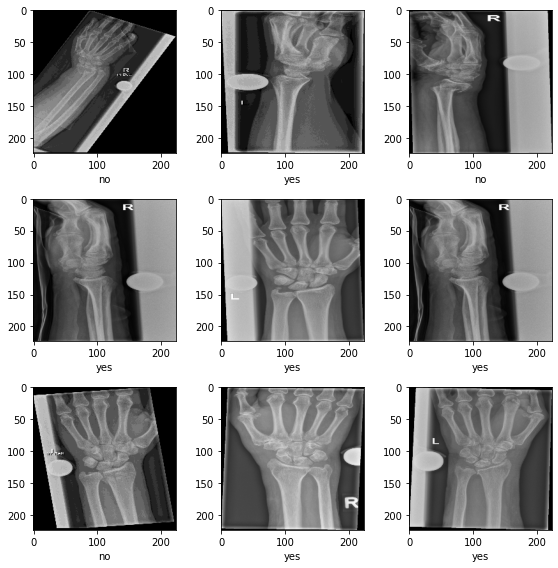

In [ ]:
import cv2 as cv
import numpy as np

plt.subplots(3, 3, figsize=(8, 8))
for i,k in enumerate(np.random.randint(num_total, size=9)):
    im = cv.imread(image_file_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_label_list[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

## Prepare training, validation and test data lists
Randomly select 10% of the dataset as validation and 10% as test.

In [ ]:
valid_frac, test_frac = 0.1, 0.1
trainX, trainY = [], []
valX, valY = [], []
testX, testY = [], []

for i in range(num_total):
    rann = np.random.random()
    if rann < valid_frac:
        valX.append(image_file_list[i])
        valY.append(image_label_list[i])
    elif rann < test_frac + valid_frac:
        testX.append(image_file_list[i])
        testY.append(image_label_list[i])
    else:
        trainX.append(image_file_list[i])
        trainY.append(image_label_list[i])

print("Training count =",len(trainX),"Validation count =", len(valX), "Test count =",len(testX))

Training count = 137 Validation count = 14 Test count = 19


## Define MONAI transforms, Dataset and Dataloader to pre-process data

In [ ]:
train_transforms = Compose([
    LoadImage(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    RandRotate(range_x=15, prob=0.5, keep_size=True),
    RandFlip(spatial_axis=0, prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5, keep_size=True),
    ToTensor()
])

val_transforms = Compose([
    LoadImage(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    ToTensor()
])

act = Activations(softmax=True)
to_onehot = AsDiscrete(to_onehot=True, n_classes=num_class)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class HandFracDataset(Dataset):

    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

train_ds = HandFracDataset(trainX, trainY, train_transforms)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)

val_ds = HandFracDataset(valX, valY, val_transforms)
val_loader = DataLoader(val_ds, batch_size=32, num_workers=2)

test_ds = HandFracDataset(testX, testY, val_transforms)
test_loader = DataLoader(test_ds, batch_size=32, num_workers=2)

## Define network and optimizer
1. Set learning rate for how much the model is updated per batch.
2. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.
And as this is just a get start tutorial, let's just train 4 epochs.
If train 10 epochs, the model can achieve 100% accuracy on test dataset.
3. Use DenseNet from MONAI and move to GPU devide, this DenseNet can support both 2D and 3D classification tasks.
4. Use Adam optimizer.

In [ ]:
device = torch.device("cuda:0")
model = DenseNet121(
    spatial_dims=2,
    in_channels=1,
    out_channels=num_class, 
    pretrained = True
).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)#Adam 1e-5
epoch_num = 30
val_interval = 1

## Model training
Execute a typical PyTorch training that run epoch loop and step loop, and do validation after every epoch.
Will save the model weights to file if got best validation accuracy.

In [ ]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        #labels = labels.unsqueeze(1)
        #labels = labels.float()
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = to_onehot(y)
            y_pred_act = act(y_pred)
            auc_metric = compute_roc_auc(y_pred_act, y_onehot)
            del y_pred_act,y_onehot
            metric_values.append(auc_metric)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if auc_metric > best_metric:
                best_metric = auc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "/content/drive/MyDrive/AI Girls/ai_wonder_girls_medical_imaging/Resources/modeling/model_outputs/best_metric_model.pth")
                print('saved new best metric model')
            print(f"current epoch: {epoch + 1} current AUC: {auc_metric:.4f}"
                  f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/30
1/4, train_loss: 0.8262
2/4, train_loss: 0.7963
3/4, train_loss: 0.6697
4/4, train_loss: 0.7085
5/4, train_loss: 0.7659
epoch 1 average loss: 0.7533
saved new best metric model
current epoch: 1 current AUC: 0.3469 current accuracy: 0.5000 best AUC: 0.3469 at epoch: 1
----------
epoch 2/30
1/4, train_loss: 0.7412
2/4, train_loss: 0.6311
3/4, train_loss: 0.6040
4/4, train_loss: 0.6579
5/4, train_loss: 0.5818
epoch 2 average loss: 0.6432
saved new best metric model
current epoch: 2 current AUC: 0.4490 current accuracy: 0.4286 best AUC: 0.4490 at epoch: 2
----------
epoch 3/30
1/4, train_loss: 0.5857
2/4, train_loss: 0.5611
3/4, train_loss: 0.5506
4/4, train_loss: 0.6762
5/4, train_loss: 0.7132
epoch 3 average loss: 0.6174
saved new best metric model
current epoch: 3 current AUC: 0.5306 current accuracy: 0.5714 best AUC: 0.5306 at epoch: 3
----------
epoch 4/30
1/4, train_loss: 0.5820
2/4, train_loss: 0.6326
3/4, train_loss: 0.4792
4/4, train_loss: 0.5991
5/4, train_l

## Plot the loss and metric

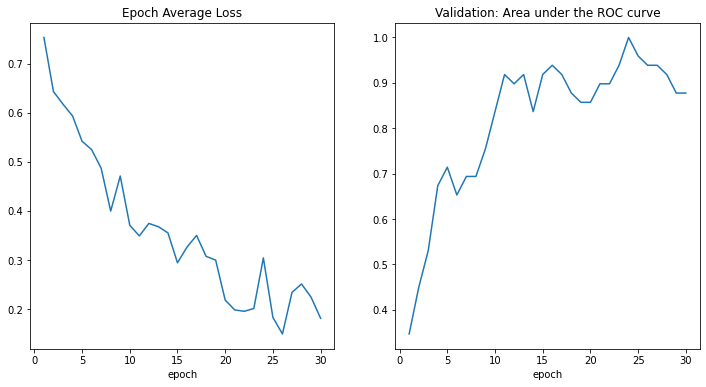

In [ ]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Validation: Area under the ROC curve")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.show()

## Evaluate the model on test dataset
After training and validation, we already got the best model on validation test.
We need to evaluate the model on test dataset to check whether it's robust and not over-fitting.
We'll use these predictions to generate a classification report.

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/AI Girls/ai_wonder_girls_medical_imaging/Resources/modeling/model_outputs/best_metric_model.pth'))
model.eval()
y_true = list()
y_pred = list()
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

         yes     0.9091    0.8333    0.8696        12
          no     0.7500    0.8571    0.8000         7

    accuracy                         0.8421        19
   macro avg     0.8295    0.8452    0.8348        19
weighted avg     0.8505    0.8421    0.8439        19





```
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)#Adam 1e-5
epoch_num = 30
```



```
 precision    recall  f1-score   support

         yes     0.9091    0.8333    0.8696        12
          no     0.7500    0.8571    0.8000         7

    accuracy                         0.8421        19
   macro avg     0.8295    0.8452    0.8348        19
weighted avg     0.8505    0.8421    0.8439        19
```





Best AUC: 0.7396 at epoch: 804


For epochs=100,torch.optim.SGD(model.parameters(), 1e-4)
```
precision    recall  f1-score   support

         yes     1.0000    0.1250    0.2222         8
          no     0.6111    1.0000    0.7586        11

    accuracy                         0.6316        19
   macro avg     0.8056    0.5625    0.4904        19
weighted avg     0.7749    0.6316    0.5328        19
```



Different architectures that could be tried : https://docs.monai.io/en/latest/_modules/monai/networks/nets/densenet.html